## preprocessing 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from collections import Counter
# nltk.download('punkt')
# nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

import tensorflow
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Embedding, Bidirectional,Dropout

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

This dataset contains sentences which can be referred to different emotions - sadness, anger, love, surprise, fear and joy.

In [31]:
test_data = pd.read_csv("test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
print("Train : ", train_data.shape)
print("Test : ", test_data.shape)
print("Validation : ", validation_data.shape)

Train :  (16000, 2)
Test :  (2000, 2)
Validation :  (2000, 2)


In [33]:
train_data['length'] = [len(x) for x in train_data['Comment']]
train_data.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


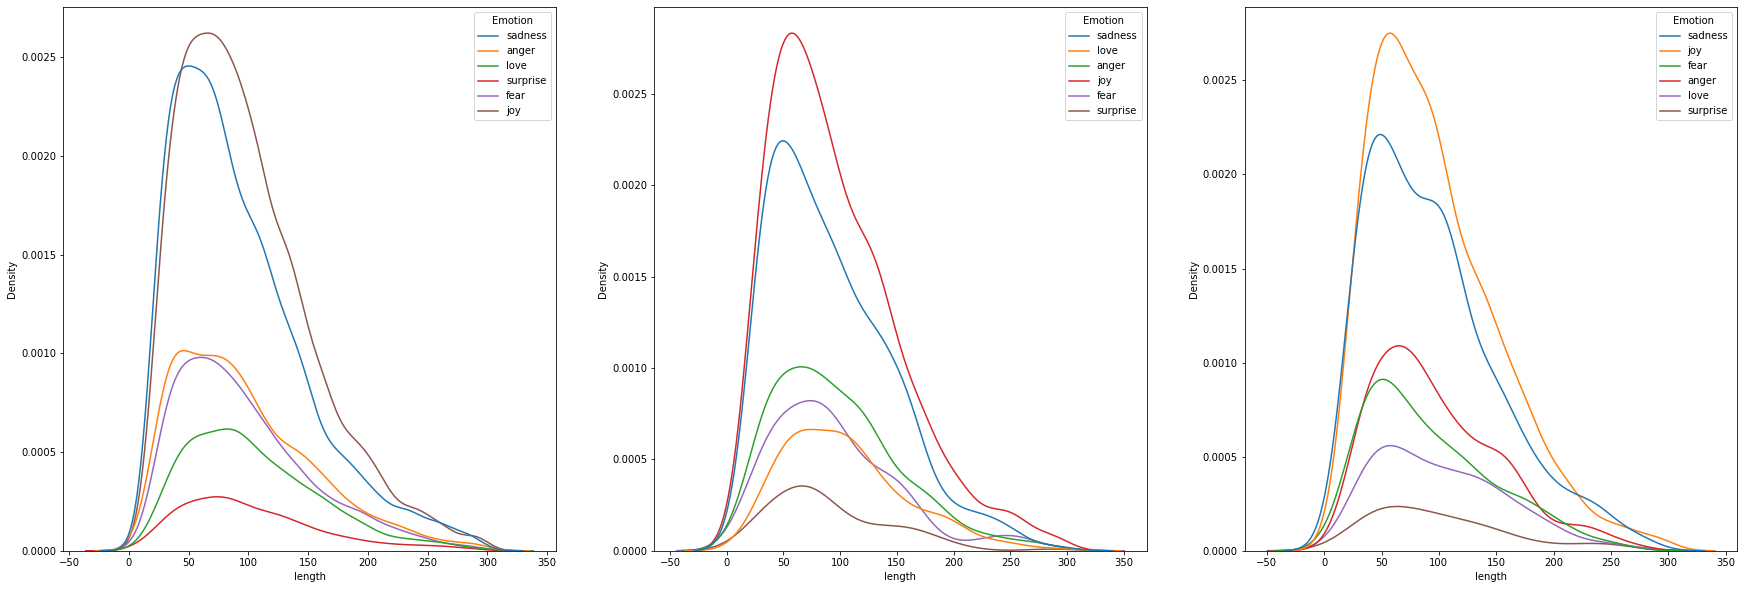

In [8]:
all_data = {'Train Data': train_data, 'Validation Data': validation_data, 'Test Data': test_data}
fig, ax = plt.subplots(1,3, figsize=(30,10))
for i, df in enumerate(all_data.values()):
    df2 = df.copy()
    df2['length'] = [len(x) for x in df2['Comment']]
    sns.kdeplot(data=df2,x='length',hue='Emotion', ax=ax[i])
plt.show()

In [32]:
# label encoding
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

use one-hot encoding      
we will try word embedding later, this has two advantages over one-hot embedding: dimensionality reduction and context similarity.

In [10]:
stopwords = set(nltk.corpus.stopwords.words('english'))
tokenizer = Tokenizer()
#tokenizer.fit_on_texts(pd.concat(X_train, axis=0))
vocabSize = 11000
max_len=train_data['length'].max()

from keras.preprocessing.text import one_hot
def text_cleaning(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=vocabSize) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')
    print(pad.shape)
    return pad

In [11]:
x_train = text_cleaning(train_data, "Comment")
x_test = text_cleaning(test_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")

(16000, 300)
(2000, 300)
(2000, 300)


In [15]:
# y_train = to_categorical(train_data["Emotion"])
# y_test = to_categorical(test_data["Emotion"])
# y_val = to_categorical(validation_data["Emotion"])

In [12]:
y_train = train_data["Emotion"]
y_test = test_data["Emotion"]
y_val = validation_data["Emotion"]

### model building

In [14]:
model = Sequential()
model.add(Embedding(input_dim=vocabSize,output_dim=150,input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

In [15]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1650000   
                                                                 
 dropout (Dropout)           (None, 300, 150)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3

In [16]:
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

In [17]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [18]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1, callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 108s 426ms/step - loss: 1.3956 - accuracy: 0.4566 - val_loss: 0.9040 - val_accuracy: 0.6815
Epoch 2/10
250/250 [==============================] - 107s 427ms/step - loss: 0.5770 - accuracy: 0.8057 - val_loss: 0.4720 - val_accuracy: 0.8325
Epoch 3/10
250/250 [==============================] - 110s 439ms/step - loss: 0.3200 - accuracy: 0.8898 - val_loss: 0.3847 - val_accuracy: 0.8810
Epoch 4/10
250/250 [==============================] - 109s 435ms/step - loss: 0.2193 - accuracy: 0.9269 - val_loss: 0.3609 - val_accuracy: 0.8820
Epoch 5/10
250/250 [==============================] - 106s 425ms/step - loss: 0.1660 - accuracy: 0.9446 - val_loss: 0.3808 - val_accuracy: 0.8795
Epoch 6/10
250/250 [==============================] - 108s 434ms/step - loss: 0.1411 - accuracy: 0.9526 - val_loss: 0.4068 - val_accuracy: 0.8715


In [19]:
model.evaluate(x_val,y_val,verbose=1)
model.evaluate(x_test,y_test,verbose=1)

63/63 [==============================] - 6s 100ms/step - loss: 0.3386 - accuracy: 0.8800


[0.3386271297931671, 0.8799999952316284]

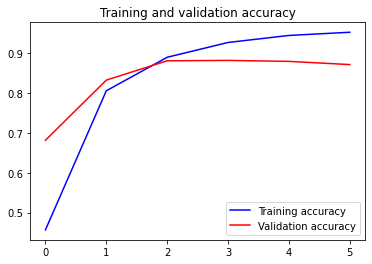

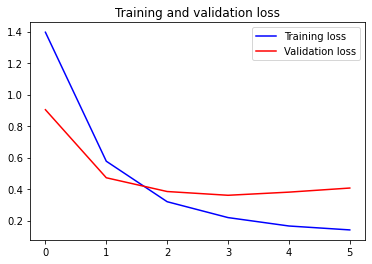

In [20]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'b', label='Training accuracy')
plt.plot(epochs,val_acc,'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b', label='Training loss')
plt.plot(epochs,val_loss,'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

use word embedding + classical models

In [45]:
train_x = train_data['Comment']
train_y = train_data['Emotion']
test_x =  test_data['Comment']
test_y = test_data['Emotion']

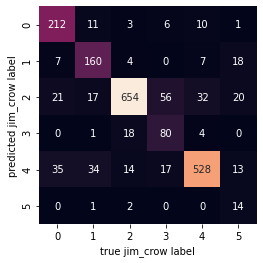

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = set(nltk.corpus.stopwords.words('english'))
CT_Vec=CountVectorizer(max_df=0.8,#remove the words appear more than 80%
                       min_df = 2,#remove the words appear less than 2 times
                    #    token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b',#Use regular expressions 
                       stop_words=frozenset(stop_words))#add stop words              
train_x_ctvec = CT_Vec.fit_transform(train_x)
test_x_ctvec = CT_Vec.transform(test_x)     

from sklearn.naive_bayes import MultinomialNB
model =  MultinomialNB()
model.fit(train_x_ctvec,train_y)
predicted_y = model.predict(test_x_ctvec)
TN = list(test_x[(predicted_y==0) & (test_y==0)])
TP = list(test_x[(predicted_y==1) & (test_y==1)])
FN = list(test_x[predicted_y < test_y])
FP = list(test_x[predicted_y > test_y])

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test_y, predicted_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [66]:
from sklearn import metrics
score = metrics.accuracy_score(test_y, predicted_y)
print(score)

0.824


In [67]:
from sklearn.metrics import classification_report
print(classification_report(test_y,predicted_y))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       275
           1       0.82      0.71      0.76       224
           2       0.82      0.94      0.87       695
           3       0.78      0.50      0.61       159
           4       0.82      0.91      0.86       581
           5       0.82      0.21      0.34        66

    accuracy                           0.82      2000
   macro avg       0.82      0.68      0.71      2000
weighted avg       0.82      0.82      0.81      2000



### compare

In [55]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [56]:
seed = 10
X = CT_Vec.fit_transform(train_x)

In [58]:

models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed,shuffle= True)
	cv_results = model_selection.cross_val_score(model, X, train_y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)



/Users/karen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/karen/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

LR: 0.891313 (0.005437)
LDA: nan (nan)
KNN: 0.585875 (0.011111)
CART: 0.877437 (0.006425)
SVM: 0.826875 (0.005047)


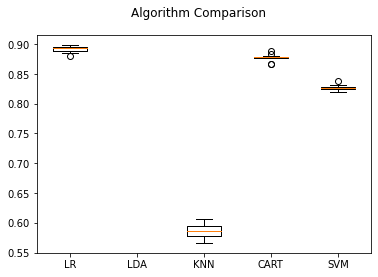

In [59]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [38]:
# Create a custom standardization function to strip HTML break tags '<br />'.
import tensorflow as tf

vocab_size = 11000
sequence_length = train_data['length'].max()

def text_cleaning_we(df, column):
    """Removing unrelevent chars, Stemming and padding"""
    stemmer = PorterStemmer()
    corpus = []
    
    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)
    return corpus
from keras.layers import TextVectorization
# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    # standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)




In [39]:
x_train_we = text_cleaning_we(train_data, "Comment")
x_test_we = text_cleaning_we(test_data, "Comment")
x_val_we = text_cleaning_we(validation_data, "Comment")

In [43]:
x_train_we = text_cleaning_we(train_data, "Comment")
# # Make a text-only dataset (no labels) and call adapt to build the vocabulary.
# text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(x_train_we)
vocab = vectorize_layer.get_vocabulary()